In [2]:
import xarray as xr
import pygmt

In [4]:
mars_data = xr.open_dataset('data/mola32.nc')
mars_data

<xarray.Dataset> Size: 133MB
Dimensions:    (latitude: 5760, longitude: 11520)
Coordinates:
  * latitude   (latitude) float32 23kB 89.98 89.95 89.92 ... -89.95 -89.98
  * longitude  (longitude) float32 46kB 0.01562 0.04688 0.07812 ... 360.0 360.0
Data variables:
    alt        (latitude, longitude) int16 133MB ...
Attributes:
    title:    MOLA Topography - 32 pixels/degree
    history:  Built from original MOLA file megt90n000fb.img

In [5]:
mars_topo = mars_data.alt.astype(float)
mars_topo = pygmt.grdsample(grid=mars_topo, translate=True, spacing=[1,1])

grdsample [WARNING]: (x_max-x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdsample [WARNING]: (y_max-y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdsample (gmtapi_init_grdheader): Please select compatible -R and -I values
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


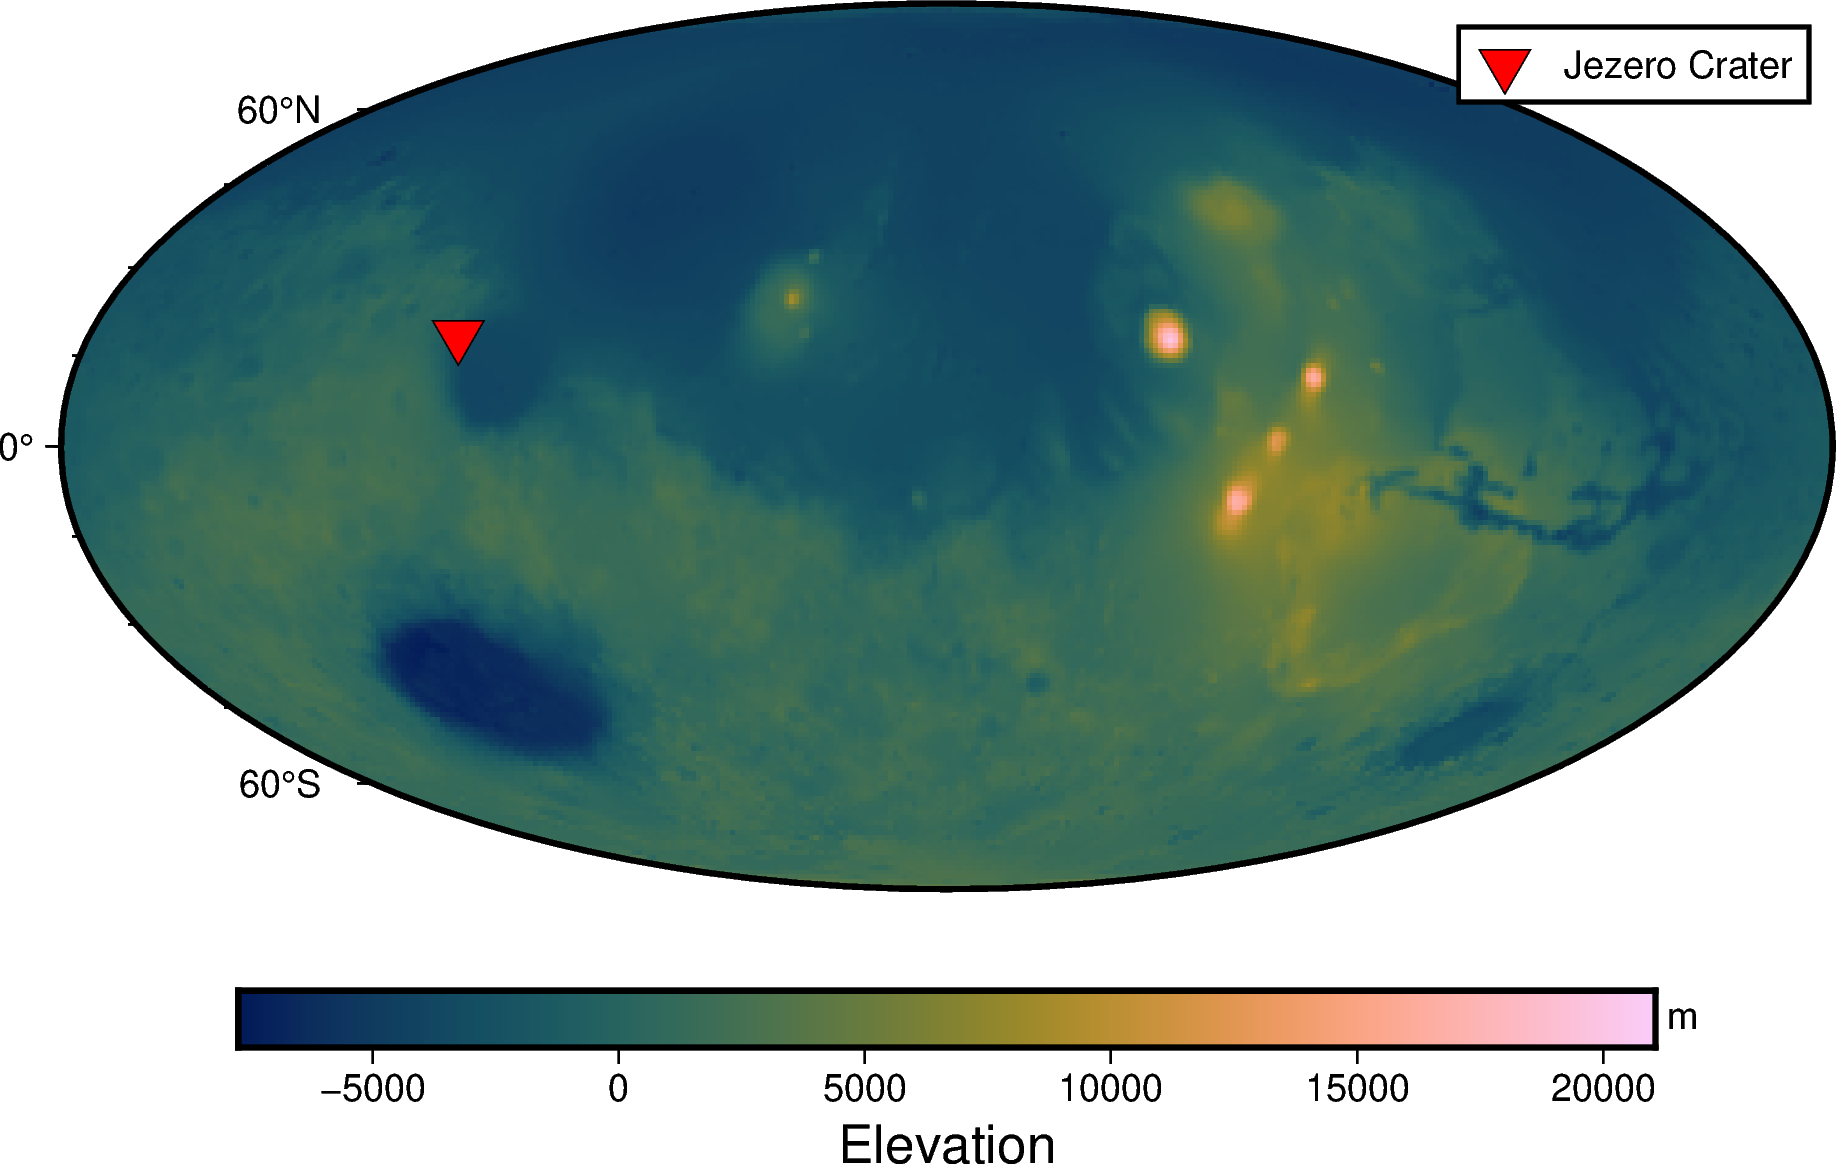

In [16]:
fig = pygmt.Figure()

fig.grdimage(grid=mars_topo,region='g',frame=True,projection='W15c',cmap='batlow')
fig.colorbar(frame=['a5000','x+lElevation','y+lm'])

# Plot the position of Jezero Crater
fig.plot(
    x=77.5,
    y=18.4,
    style='i0.5c',  # 'i' for an inverted triangle, '0.5c' for the size (0.5 cm)
    color='red',  # Point color
    pen='black',  # Outline color
    label='Jezero Crater'  # Label for the legend
)

# Define the legend
fig.legend(
    position='JTR+jTR+o0.2c',  # Position: Justify Top Right, plus offset
    box='+gwhite+p1p'  # White background with a black border
)

fig.show()